<a href="https://colab.research.google.com/github/vicentcamison/idal_ia3/blob/main/3%20Aprendizaje%20profundo%20(II)/Sesion%205/B4_Emojify_GRUs_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![IDAL](https://i.imgur.com/tIKXIG1.jpg)  

#**Máster en Inteligencia Artificial Avanzada y Aplicada:  IA^3**
---

#<strong><center>Emojify!</center></strong>

En este documento vamos a utilizar representaciones vectoriales de palabras para construir un Emojificador. 

¿Alguna vez has querido hacer tus mensajes de texto más expresivos? Tu aplicación emojificadora te ayudará a hacerlo. La finalidad es que en lugar de escribir "Congratulations on the promotion! Lets get coffee and talk. Love you!" , el emojificador puede convertirlo automáticamente en "Congratulations on the promotion! 👍 Lets get coffee and talk. ☕️ Love you! ❤️"

*NOTA: Debido a que el vector de entrenamiento de emmbedings es en inglés, hemos de trabajar con frases en inglés. Siempre es bueno practicar idiomas!*

Implementarás un modelo que introduzca una frase (como "¡Vamos a ver el partido de béisbol esta noche!") y encuentre el emoji más apropiado para ser utilizado con esta frase (⚾️). En muchas interfaces de emoji, tienes que recordar que ❤️ es el símbolo del "corazón" y no el del "amor". Pero si utilizas vectores de palabras, verás que incluso si tu conjunto de entrenamiento relaciona explícitamente sólo unas pocas palabras con un emoji en particular, tu algoritmo será capaz de generalizar y asociar palabras en el conjunto de prueba al mismo emoji incluso si esas palabras ni siquiera aparecen en el conjunto de entrenamiento. Esto te permite construir un clasificador preciso de frases a emojis, incluso utilizando un conjunto de entrenamiento pequeño. 

En el ejercicio, empezaremos con un modelo de referencia (Emojifier-V1) que utiliza *word embeddings*, y luego construiremos un modelo más sofisticado (Emojifier-V2) que incorpora una GRU. 



In [ ]:
!pip install emoji

In [ ]:
import numpy as np
from emo_utils import *
import emoji
import matplotlib.pyplot as plt

%matplotlib inline

Para el ejercicio necesitamos acceso a varios documentos, de forma que lo mejor es realizar la conexión con nuestro googel Drive donde debemos tener los siguientes archivos: 
* train_emoji.csv
* tesss.csv
* glove.6B.50d.txt

Tambien es necesario poner el fichero "emo_utils.py" en el directorio "/content" de la ejecucion temporal del notebook

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 1 - Baseline model: Emojifier-V1

### 1.1 - Dataset EMOJISET
Empezamos por construir un clasificador de referencia sencillo. 

Se tiene un pequeño conjunto de datos (X, Y) donde
- X contiene 127 frases (cadenas)
- Y contiene una etiqueta entera entre 0 y 4 que corresponde a un emoji para cada frase
![Emojiset](https://i.imgur.com/KhFJKMv.png)
<caption><center> **Figura 1**: EMOJISET - un problema de clasificación con 5 clases. Aquí se dan algunos ejemplos de frases. </center></caption>

Vamos a cargar el conjunto de datos utilizando el código siguiente. Dividimos el conjunto de datos entre entrenamiento (127 ejemplos) y prueba (56 ejemplos).

In [ ]:
X_train, Y_train = read_csv('/content/gdrive/MyDrive/Colab Notebooks/IA3_data/train_emoji.csv')
X_test, Y_test = read_csv('/content/gdrive/MyDrive/Colab Notebooks/IA3_data/tesss.csv')

In [ ]:
maxLen = len(max(X_train, key=len).split())

Ejecute la siguiente celda para imprimir las frases de X_train y las etiquetas correspondientes de Y_train. Cambie el `índice` para ver diferentes ejemplos. Debido al tipo de letra que utiliza el cuaderno iPython, el emoji del corazón puede ser de color negro en lugar de rojo.

In [ ]:
index = 1
print(X_train[index], label_to_emoji(Y_train[index]))

I am proud of your achievements 😄


### 1.2 - Visión general del Emojifier-V1

En esta parte, vas a implementar un modelo de base llamado "Emojifier-v1".  
<center>

![Emojifier v1](https://i.imgur.com/Lxj2QM0.png)
<caption><center> **Figura 2**: Modelo de referencia (Emojifier-V1).</center></caption>.
</center>

La entrada del modelo es una cadena correspondiente a una frase (por ejemplo, "Te quiero"). En el código, la salida será un vector de probabilidad de forma (1,5), que luego se pasa en una capa argmax para extraer el índice de la salida más probable del emoji.

Para obtener nuestras etiquetas en un formato adecuado para el entrenamiento de un clasificador softmax, vamos a convertir $Y$ de su forma actual $(m, 1)$ en una "representación de un solo disparo" $(m, 5)$, donde cada fila es un vector de un solo disparo que da la etiqueta de un ejemplo. Aquí, `Y_oh` significa "Y-one-hot" en los nombres de las variables `Y_oh_train` y `Y_oh_test`: 


In [ ]:
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

Veamos lo que hizo `convert_to_one_hot()`. Siéntase libre de cambiar `index` para imprimir diferentes valores. 

In [ ]:
index = 50
print(Y_train[index], "is converted into one hot", Y_oh_train[index])

0 is converted into one hot [1. 0. 0. 0. 0.]


Todos los datos están listos para ser introducidos en el modelo Emojify-V1. Vamos a implementar el modelo

### 1.3 - Implementación del Emojifier-V1

Como se muestra en la Figura (2), el primer paso es convertir una frase de entrada en la representación de vectores de palabras, que luego se promedian juntos. Al igual que en el ejercicio anterior, utilizaremos incrustaciones GloVe preentrenadas de 50 dimensiones. Ejecute la siguiente celda para cargar el `word_to_vec_map`, que contiene todas las representaciones vectoriales.

In [ ]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/content/gdrive/MyDrive/Colab Notebooks/IA3_data/glove.6B.50d.txt')

Has cargado:
- `word_to_index`: mapeo del diccionario desde las palabras a sus índices en el vocabulario (400.001 palabras, con los índices válidos que van de 0 a 400.000)
- `index_to_word`: diccionario que relaciona los índices con las palabras correspondientes en el vocabulario.
- `word_to_vec_map`: diccionario que asigna las palabras a su representación vectorial en GloVe.

Ejecute la siguiente celda para comprobar si funciona.

In [ ]:
word = "cucumber"
index = 289846
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(index) + "th word in the vocabulary is", index_to_word[index])

the index of cucumber in the vocabulary is 113317
the 289846th word in the vocabulary is potatos


Vamos a implementar `sentence_to_avg()`. Deberá realizar dos pasos:
1. Convertir cada frase a minúsculas, y luego dividir la frase en una lista de palabras. Puede ser útil utilizar `X.lower()` y `X.split()`. 
2. Para cada palabra de la frase, acceda a su representación GloVe. A continuación, promedia todos estos valores.

In [ ]:
def sentence_to_avg(sentence, word_to_vec_map):
    """
    Convierte una frase (cadena) en una lista de palabras (cadenas). Extrae la representación GloVe de cada palabra
    y promedia su valor en un único vector que codifica el significado de la frase.
    
    Argumentos:
    frase -- cadena, un ejemplo de entrenamiento de X
    word_to_vec_map -- diccionario que mapea cada palabra de un vocabulario en su representación vectorial de 50 dimensiones
    
    Devuelve:
    avg -- vector medio que codifica la información sobre la frase, matriz numpy de forma (50,)
    """

    # Step 1: Split sentence into list of lower case words (≈ 1 line)
    words = [i.lower() for i in sentence.split()]

    # Initialize the average word vector, should have the same shape as your word vectors.
    avg = np.zeros((50,))
    
    # Step 2: average the word vectors. You can loop over the words in the list "words".
    for w in words:
        avg += word_to_vec_map[w]
    avg = avg / len(words)
    
    return avg

In [ ]:
avg = sentence_to_avg("Morrocan couscous is my favorite dish", word_to_vec_map)
print("avg = ", avg)

avg =  [-0.008005    0.56370833 -0.50427333  0.258865    0.55131103  0.03104983
 -0.21013718  0.16893933 -0.09590267  0.141784   -0.15708967  0.18525867
  0.6495785   0.38371117  0.21102167  0.11301667  0.02613967  0.26037767
  0.05820667 -0.01578167 -0.12078833 -0.02471267  0.4128455   0.5152061
  0.38756167 -0.898661   -0.535145    0.33501167  0.68806933 -0.2156265
  1.797155    0.10476933 -0.36775333  0.750785    0.10282583  0.348925
 -0.27262833  0.66768    -0.10706167 -0.283635    0.59580117  0.28747333
 -0.3366635   0.23393817  0.34349183  0.178405    0.1166155  -0.076433
  0.1445417   0.09808667]


**Salida esperada**:

<table>
    <tr>
        <td>
            **avg= **
        </td>
        <td>
           [-0.008005    0.56370833 -0.50427333  0.258865    0.55131103  0.03104983
 -0.21013718  0.16893933 -0.09590267  0.141784   -0.15708967  0.18525867
  0.6495785   0.38371117  0.21102167  0.11301667  0.02613967  0.26037767
  0.05820667 -0.01578167 -0.12078833 -0.02471267  0.4128455   0.5152061
  0.38756167 -0.898661   -0.535145    0.33501167  0.68806933 -0.2156265
  1.797155    0.10476933 -0.36775333  0.750785    0.10282583  0.348925
 -0.27262833  0.66768    -0.10706167 -0.283635    0.59580117  0.28747333
 -0.3366635   0.23393817  0.34349183  0.178405    0.1166155  -0.076433
  0.1445417   0.09808667]
        </td>
    </tr>
</table>

#### Modelo

Ahora tenemos todas las piezas para terminar de implementar la función `model()`. Después de usar `sentence_to_avg()` necesitas pasar el promedio a través de la propagación hacia adelante, calcular el costo, y luego retropropagar para actualizar los parámetros del softmax. 

Vamso ahora a implementar la función `model()` descrita en la Figura (2). Asumiendo aquí que $Yoh$ ("Y one hot") es la codificación one-hot de las etiquetas de salida, las ecuaciones que necesitas implementar en el forward pass y para calcular el coste de la entropía cruzada son

$$ z^{(i)} = W . avg^{(i)} + b$$
$$ a^{(i)} = softmax(z^{(i)})$$
$$ \mathcal{L}^{(i)} = - \sum_{k = 0}^{n_y - 1} Yoh^{(i)}_k * log(a^{(i)}_k)$$

Es posible llegar a una implementación vectorizada más eficiente. Pero ya que estamos utilizando un bucle for para convertir las sentencias de una en una en la representación $avg^{(i)}$ de todos modos, no vamos a molestarnos esta vez. 


In [ ]:
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    """
    Modelo para entrenar representaciones de vectores de palabras en numpy.
    
    Argumentos:
    X -- datos de entrada, array numpy de frases como cadenas, de forma (m, 1)
    Y -- etiquetas, matriz numpy de enteros entre 0 y 7, matriz numpy de forma (m, 1)
    word_to_vec_map -- diccionario que mapea cada palabra de un vocabulario en su representación vectorial de 50 dimensiones
    learning_rate -- tasa de aprendizaje para el algoritmo de descenso de gradiente estocástico
    num_iterations -- número de iteraciones
    
    Devuelve:
    pred -- vector de predicciones, numpy-array de forma (m, 1)
    W -- matriz de pesos de la capa softmax, de forma (n_y, n_h)
    b -- sesgo de la capa softmax, de forma (n_y,)
    """
    
    np.random.seed(1)

    # Define number of training examples
    m = Y.shape[0]                          # number of training examples
    n_y = 5                                 # number of classes  
    n_h = 50                                # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y, C = n_y) 
    
    # Optimization loop
    for t in range(num_iterations):                       # Loop over the number of iterations
        for i in range(m):                                # Loop over the training examples
            
  
            # Average the word vectors of the words from the i'th training example
            avg = sentence_to_avg(X[i], word_to_vec_map)

            # Forward propagate the avg through the softmax layer
            z = np.dot(W, avg) + b
            a = softmax(z)

            # Compute cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            cost = -np.sum(np.multiply(Y_oh[i], np.log(a)))

            
            # Compute gradients 
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map)

    return pred, W, b

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(np.eye(5)[Y_train.reshape(-1)].shape)
print(X_train[0])
print(type(X_train))
Y = np.asarray([5,0,0,5, 4, 4, 4, 6, 6, 4, 1, 1, 5, 6, 6, 3, 6, 3, 4, 4])
print(Y.shape)

X = np.asarray(['I am going to the bar tonight', 'I love you', 'miss you my dear',
 'Lets go party and drinks','Congrats on the new job','Congratulations',
 'I am so happy for you', 'Why are you feeling bad', 'What is wrong with you',
 'You totally deserve this prize', 'Let us go play football',
 'Are you down for football this afternoon', 'Work hard play harder',
 'It is suprising how people can be dumb sometimes',
 'I am very disappointed','It is the best day in my life',
 'I think I will end up alone','My life is so boring','Good job',
 'Great so awesome'])

print(X.shape)
print(np.eye(5)[Y_train.reshape(-1)].shape)
print(type(X_train))

(132,)
(132,)
(132, 5)
never talk to me again
<class 'numpy.ndarray'>
(20,)
(20,)
(132, 5)
<class 'numpy.ndarray'>


Ejecute la siguiente celda para entrenar su modelo y aprender los parámetros softmax (W,b). 

In [ ]:
pred, W, b = model(X_train, Y_train, word_to_vec_map)
#print(pred)

Epoch: 0 --- cost = 1.9520498812810076
Accuracy: 0.3484848484848485
Epoch: 100 --- cost = 0.07971818726014807
Accuracy: 0.9318181818181818
Epoch: 200 --- cost = 0.04456369243681402
Accuracy: 0.9545454545454546
Epoch: 300 --- cost = 0.03432267378786059
Accuracy: 0.9696969696969697


**Salida esperada** (on a subset of iterations):

<table>
    <tr>
        <td>
            **Epoch: 0**
        </td>
        <td>
           cost = 1.95204988128
        </td>
        <td>
           Accuracy: 0.348484848485
        </td>
    </tr>


<tr>
        <td>
            **Epoch: 100**
        </td>
        <td>
           cost = 0.0797181872601
        </td>
        <td>
           Accuracy: 0.931818181818
        </td>
    </tr>
    
<tr>
        <td>
            **Epoch: 200**
        </td>
        <td>
           cost = 0.0445636924368
        </td>
        <td>
           Accuracy: 0.954545454545
        </td>
    </tr>
    
    <tr>
        <td>
            **Epoch: 300**
        </td>
        <td>
           cost = 0.0343226737879
        </td>
        <td>
           Accuracy: 0.969696969697
        </td>
    </tr>
</table>

Genial. El modelo tiene una precisión bastante alta en el conjunto de entrenamiento. Veamos ahora cómo lo hace en el conjunto de pruebas. 

### 1.4 - Examinar el rendimiento del conjunto de pruebas 



In [ ]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.9772727272727273
Test set:
Accuracy: 0.8571428571428571


La adivinación aleatoria habría tenido un 20% de precisión dado que hay 5 clases. Se trata de un rendimiento bastante bueno después de entrenar con sólo 127 ejemplos. 

En el conjunto de entrenamiento, el algoritmo vio la frase "*I love you*" con la etiqueta ❤️. Sin embargo, puedes comprobar que la palabra "adore" no aparece en el conjunto de entrenamiento. No obstante, veamos qué ocurre si se escribe "i adore you*".



In [ ]:
X_my_sentences = np.array(["i adore you", "i love you", "funny lol", "lets play with a ball", "food is ready", "not feeling happy"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
print_predictions(X_my_sentences, pred)

Accuracy: 0.8333333333333334

i adore you ❤️
i love you ❤️
funny lol 😄
lets play with a ball ⚾
food is ready 🍴
not feeling happy 😄


Sorprendente. Como *adore* tiene una embedding similar a la de *love*, el algoritmo ha generalizado correctamente incluso con una palabra que nunca había visto antes. Palabras como *heart*, *dear*, *beloved* or *adore* tienen vectores de embedding similares a *love*, por lo que también podrían funcionar; siéntase libre de modificar las entradas anteriores y probar una variedad de frases de entrada. ¿Qué tal funciona?

Observa que no acierta con "not feeling happy". Este algoritmo ignora el orden de las palabras, por lo que no es bueno para entender frases como "no happy". 

Imprimir la matriz de confusión también puede ayudar a entender qué clases son más difíciles para tu modelo. Una matriz de confusión muestra la frecuencia con la que un ejemplo cuya etiqueta es de una clase (clase "real") es etiquetado erróneamente por el algoritmo con una clase diferente (clase "predicha"). 




(56,)
           ❤️    ⚾    😄    😞   🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            6    0    0    1    0    7
1            0    8    0    0    0    8
2            2    0   16    0    0   18
3            1    1    2   12    0   16
4            0    0    1    0    6    7
All          9    9   19   13    6   56


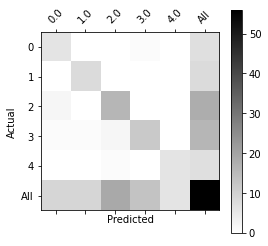

In [ ]:
print(Y_test.shape)
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

<font color='blue'>
**Lo MAS IMPORTANTE de esta parte**:

- Incluso con 127 ejemplos de entrenamiento, puedes obtener un modelo razonablemente bueno para la emojificación. Esto se debe al poder de generalización que le dan los vectores de palabras. 
- Emojify-V1 tendrá un mal rendimiento en frases como *"Esta película no es buena y no es agradable "* porque no entiende las combinaciones de palabras -simplemente promedia todos los vectores de embedding de las palabras, sin prestar atención al orden de las palabras. En la siguiente parte construirás un algoritmo mejor. 


## 2 - Emojifier-V2: Usando GRUs en Keras: 

Vamos a construir un modelo con GRUS que tome como entrada secuencias de palabras. Este modelo será capaz de tener en cuenta el orden de las palabras. Emojifier-V2 continuará utilizando incrustaciones de palabras pre-entrenadas para representar las palabras, pero las alimentará en un GRU, cuyo trabajo es predecir el emoji más apropiado. 

Ejecuta la siguiente celda para cargar los paquetes Keras.

In [ ]:
import numpy as np
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, GRU, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
np.random.seed(1)

### 2.1 - Visión general del modelo

Aquí está el Emojifier-v2 que implementarás:

![Emojifier v2](https://i.imgur.com/zDC1Z2U.png)
<caption><center> **Figura 3**: Emojifier-V2. Un clasificador de secuencias RGU de 2 capas. </center></caption>



### 2.2 Keras y el mini-batching 

En este ejercicio, queremos entrenar a Keras usando mini-lotes. Sin embargo, la mayoría de los marcos de aprendizaje profundo requieren que todas las secuencias en el mismo mini-batch tengan la misma longitud. Esto es lo que permite que la vectorización funcione: Si tuviéramos una frase de 3 palabras y otra de 4, los cálculos necesarios para ellas son diferentes (una requiere 3 pasos de un GRU, otra requiere 4 pasos), por lo que no es posible hacer ambas al mismo tiempo.

La solución común a esto es utilizar el relleno. En concreto, se establece una longitud máxima de secuencia y se rellenan todas las secuencias con la misma longitud. Por ejemplo, si la longitud máxima de la secuencia es 20, podríamos rellenar cada frase con "0" para que cada frase de entrada tenga una longitud de 20. Así, una frase "te quiero" se representaría como $(e_{i}, e_{love}, e_{you}, \vec{0}, \vec{0}, \ldots, \vec{0})$. En este ejemplo, cualquier frase de más de 20 palabras tendría que ser truncada. Una forma sencilla de elegir la longitud máxima de la secuencia es simplemente elegir la longitud de la frase más larga del conjunto de entrenamiento. 


### 2.3 - La capa de embedding

En Keras, la matriz de embedding se representa como una "capa", y mapea enteros positivos (índices correspondientes a las palabras) en vectores densos de tamaño fijo (los vectores de embedding). Puede ser entrenada o inicializada con una embedding preentrenada. En esta parte, aprenderás a crear una capa [Embedding()](https://keras.io/layers/embeddings/) en Keras, inicializándola con los vectores GloVe de 50 dimensiones cargados anteriormente en el cuaderno. Como nuestro conjunto de entrenamiento es bastante pequeño, no actualizaremos las incrustaciones de palabras, sino que dejaremos sus valores fijos. Pero en el código siguiente, mostraremos cómo Keras permite entrenar o dejar fija esta capa.  

La capa `Embedding()` toma como entrada una matriz entera de tamaño (tamaño del lote, longitud máxima de la entrada). Esta corresponde a sentencias convertidas en listas de índices (enteros), como se muestra en la siguiente figura.
![Embedding1](https://i.imgur.com/g4xvysH.png)

<caption><center> **Figura 4**: Capa de embedding. Este ejemplo muestra la propagación de dos ejemplos a través de la capa de embedding. Ambos han sido rellenados con cero hasta una longitud de `max_len=5`. La dimensión final de la representación es `(2,max_len,50)` porque las incrustaciones de palabras que estamos utilizando son de 50 dimensiones. </center></caption>

El mayor número entero (es decir, el índice de la palabra) en la entrada no debe ser mayor que el tamaño del vocabulario. La capa da salida a un array de forma (tamaño del lote, longitud máxima de la entrada, dimensión de los vectores de palabras).

El primer paso es convertir todas las frases de entrenamiento en listas de índices, y luego poner a cero todas estas listas para que su longitud sea la de la frase más larga. 

Implementamos la función siguiente para convertir X (matriz de sentencias como cadenas) en una matriz de índices correspondientes a las palabras de las sentencias. La forma de salida debe ser tal que se pueda dar a `Embedding()` (descrito en la Figura 4). 

In [ ]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Convierte una matriz de frases (cadenas) en una matriz de índices correspondientes a las palabras de las frases.
    La forma de salida debe ser tal que se pueda dar a `Embedding()` (descrito en la Figura 4). 
    
    Argumentos:
    X -- matriz de frases (cadenas), de forma (m, 1)
    word_to_index -- un diccionario que contiene cada palabra asignada a su índice
    max_len -- número máximo de palabras en una frase. Se puede asumir que cada frase en X no es más larga que esto. 
    
    Devuelve:
    X_indices -- array de índices correspondientes a las palabras de las sentencias de X, de forma (m, max_len)
    """
    # number of training examples
    m = X.shape[0]                                   

    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))

    # loop over training examples
    for i in range(m):                               
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = [w.lower() for w in X[i].split()]
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            X_indices[i, j] = word_to_index[w]
            # Increment j to j + 1
            j += 1
    
    return X_indices

Chequeamos `sentences_to_indices()`

In [ ]:
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1,word_to_index, max_len = 5)
print("X1 =", X1)
print("X1_indices =", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices = [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


**Salida esperada**:

<table>
    <tr>
        <td>
            **X1 =**
        </td>
        <td>
           ['funny lol' 'lets play football' 'food is ready for you']
        </td>
    </tr>
    <tr>
        <td>
            **X1_indices =**
        </td>
        <td>
           [[ 155345.  225122.       0.       0.       0.] <br>
            [ 220930.  286375.  151266.       0.       0.] <br>
            [ 151204.  192973.  302254.  151349.  394475.]]
        </td>
    </tr>
</table>

Vamos a construir la capa `Embedding()` en Keras, utilizando vectores de palabras pre-entrenados. Una vez construida esta capa, le pasaremos la salida de `sentences_to_indices()` como entrada, y la capa `Embedding()` devolverá las incrustaciones de palabras para una frase. 

Implementaremos la capa `pretrained_embedding()`. Deberás realizar los siguientes pasos:
1. Inicializar la matriz de embedding como un array numpy de ceros con la forma correcta.
2. Rellenar la matriz de embedding con todas las incrustaciones de palabras extraídas de `word_to_vec_map`.
3. Definir la capa de embedding de Keras. Utilice [Embedding()](https://keras.io/layers/embeddings/). Asegúrese de hacer que esta capa no sea entrenable, estableciendo `trainable = False` cuando llame a `Embedding()`. Si establece `trainable = True`, entonces permitirá que el algoritmo de optimización modifique los valores de las incrustaciones de palabras. 
4. Establezca los pesos de embedding para que sean iguales a la matriz de embedding 

In [ ]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Crea una capa de Keras Embedding() y carga en ella vectores preentrenados GloVe de 50 dimensiones.
    
    Argumentos:
    word_to_vec_map -- diccionario que mapea las palabras a su representación vectorial en GloVe.
    word_to_index -- diccionario que mapea las palabras a sus índices en el vocabulario (400.001 palabras)

    Devuelve:
    embedding_layer -- instancia de Keras de la capa preentrenada
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)

    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [ ]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

weights[0][1][3] = -0.3403


** Salida esperada**:

<table>
    <tr>
        <td>
            **weights[0][1][3] =**
        </td>
        <td>
           -0.3403
        </td>
    </tr>
</table>

## 2.3 Construir el Emojifier-V2

Construyamos ahora el modelo Emojifier-V2. Lo harás utilizando la capa de embedding que has construido, y alimentarás su salida a una red GRU. 
![Emojifier v2](https://i.imgur.com/zDC1Z2U.png)
<caption><center> **Figura 3**: Emojifier-v2. Un clasificador de secuencias GRU de 2 capas. </center></caption>





Implementaremos `Emojify_V2()`, que construye un gráfico Keras de la arquitectura mostrada en la Figura 3. El modelo toma como entrada un array de frases de forma (`m`, `max_len`, ) definido por `input_shape`. Debería dar como salida un vector de probabilidad softmax de forma (`m`, `C = 5`). Puede necesitar `Input(shape = ..., dtype = '...')`, [GRU()](https://keras.io/layers/recurrent/#GRU), [Dropout()](https://keras.io/layers/core/#dropout), [Dense()](https://keras.io/layers/core/#dense), y [Activation()](https://keras.io/activations/).

In [ ]:
# Emojify_V2

def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    """
    Función que crea el gráfico del modelo Emojify-v2.
    
    Argumentos:
    input_shape -- forma de la entrada, normalmente (max_len,)
    word_to_vec_map -- diccionario que mapea cada palabra del vocabulario en su representación vectorial de 50 dimensiones
    word_to_index -- diccionario que asigna las palabras a sus índices en el vocabulario (400.001 palabras)

    Devuelve:
    model -- una instancia del modelo en Keras
    """

    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an GRU layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = GRU(128, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another GRU layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = GRU(128, return_sequences=False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(5)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

Ejecute la siguiente celda para crear su modelo y comprobar su resumen. Como todas las frases del conjunto de datos tienen menos de 10 palabras, elegimos `max_len = 10`.  
Si revisamos la arquitectura, vemos que utiliza "20.168.887" parámetros, de los cuales 20.000.050 (las incrustaciones de palabras) no son entrenables, y los 168.837 restantes sí. Como nuestro vocabulario tiene 400.001 palabras (con índices válidos de 0 a 400.000) hay 400.001*50 = 20.000.050 parámetros no entrenables. 

In [ ]:
model = Emojify_V2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
gru (GRU)                    (None, 10, 128)           69120     
_________________________________________________________________
dropout (Dropout)            (None, 10, 128)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 645   

Como siempre, después de crear tu modelo en Keras, necesitas compilarlo y definir qué pérdida, optimizador y métrica quieres usar. Compila tu modelo usando la pérdida `categorical_crossentropy`, el optimizador `adam` y la métrica `['accuracy']`:

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Es hora de entrenar tu modelo. Tu `modelo` de Emojifier-V2 toma como entrada un array de formas (`m`, `max_len`) y da como salida vectores de probabilidad de formas (`m`, `número de clases`). Por lo tanto, tenemos que convertir X_train (matriz de frases como cadenas) en X_train_indices (matriz de frases como lista de índices de palabras), e Y_train (etiquetas como índices) en Y_train_oh (etiquetas como vectores de un solo golpe).

In [ ]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)

Ajusta el modelo Keras en `X_train_indices` y `Y_train_oh`. Utilizaremos `epochs = 50` y `batch_size = 32`.

In [ ]:
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True)

Epoch 1/50
5/5 [==============================] - 0s 20ms/step - loss: 0.0149 - accuracy: 1.0000
Epoch 2/50
5/5 [==============================] - 0s 20ms/step - loss: 0.0073 - accuracy: 1.0000
Epoch 3/50
5/5 [==============================] - 0s 19ms/step - loss: 0.0072 - accuracy: 1.0000
Epoch 4/50
5/5 [==============================] - 0s 20ms/step - loss: 0.0088 - accuracy: 1.0000
Epoch 5/50
5/5 [==============================] - 0s 20ms/step - loss: 0.0059 - accuracy: 1.0000
Epoch 6/50
5/5 [==============================] - 0s 22ms/step - loss: 0.0063 - accuracy: 1.0000
Epoch 7/50
5/5 [==============================] - 0s 19ms/step - loss: 0.0056 - accuracy: 1.0000
Epoch 8/50
5/5 [==============================] - 0s 21ms/step - loss: 0.0052 - accuracy: 1.0000
Epoch 9/50
5/5 [==============================] - 0s 19ms/step - loss: 0.0046 - accuracy: 1.0000
Epoch 10/50
5/5 [==============================] - 0s 20ms/step - loss: 0.0047 - accuracy: 1.0000
Epoch 11/50
5/5 [============

El modelo debe tener una precisión cercana al **100%** en el conjunto de entrenamiento. La precisión exacta que obtenga puede ser un poco diferente. Ejecuta la siguiente celda para evaluar tu modelo en el conjunto de pruebas. 

In [ ]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

2/2 [==============================] - 0s 8ms/step - loss: 0.4234 - accuracy: 0.8571

Test accuracy =  0.8571428656578064


Debería obtener una precisión de la prueba entre el 80% y el 95%. Ejecuta la celda de abajo para ver los ejemplos mal etiquetados. 

In [ ]:
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:'+ label_to_emoji(Y_test[i]) + ' prediction: '+ X_test[i] + label_to_emoji(num).strip())

Expected emoji:😞 prediction: This girl is messing with me	❤️
Expected emoji:❤️ prediction: I love taking breaks	😞
Expected emoji:😄 prediction: you brighten my day	❤️
Expected emoji:😞 prediction: she is a bully	❤️
Expected emoji:😞 prediction: My life is so boring	❤️
Expected emoji:😄 prediction: will you be my valentine	❤️
Expected emoji:⚾ prediction: he can pitch really well	😄
Expected emoji:❤️ prediction: family is all I have	😞


Ahora puedes probarlo con tu propio ejemplo. Escribe tu propia frase a continuación. 

In [ ]:
# Juega con diferentes frases para ver las predecciones. Asegurate que las palabras existen en Glove embeddings.  
# Sentences= ["i adore you", "i love you", "funny lol", "lets play with a ball", "food is ready", "not feeling happy"])
x_test = np.array(['congratulations for the job'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

congratulations for the job 😄


Prueba diferentes frases y observa los resultados. Ten en cuenta varias cosas: 
* las salidas de Keras son ligeramente aleatorias cada vez, así que puede que no haya obtenido el mismo resultado)
* El modelo actual todavía no es muy robusto a la hora de entender la negación (como "no ser feliz") porque el conjunto de entrenamiento es pequeño y, por tanto, no tiene muchos ejemplos de negación. Pero si el conjunto de entrenamiento fuera más grande, el modelo GRU sería mucho mejor que el modelo Emojify-V1 para entender esas frases complejas. 

¿Que posibilidades de mejora crees que tiene? ¿Podríamos usar alguna arquitectura mejor?


**Lo que debes recordar**:
- Si tiene una tarea de PLN en la que el conjunto de entrenamiento es pequeño, el uso de incrustaciones de palabras puede ayudar a su algoritmo de forma significativa. Las incrustaciones de palabras permiten que tu modelo trabaje con palabras en el conjunto de prueba que pueden no haber aparecido en tu conjunto de entrenamiento. 
- El entrenamiento de modelos de secuencia en Keras (y en la mayoría de los otros marcos de aprendizaje profundo) requiere algunos detalles importantes:
    - Para utilizar minilotes, las secuencias deben ser rellenadas para que todos los ejemplos de un minilote tengan la misma longitud. 
    - Una capa `Embedding()` puede ser inicializada con valores pre-entrenados. Estos valores pueden ser fijos o entrenados posteriormente en su conjunto de datos. Sin embargo, si su conjunto de datos etiquetados es pequeño, normalmente no vale la pena intentar entrenar un gran conjunto preentrenado de incrustaciones.   
    - `GRU()` tiene una bandera llamada `return_sequences` para decidir si quieres devolver todos los estados ocultos o sólo el último. 
    - Puedes usar `Dropout()` justo después de `GRU()` para regularizar tu red. 

## Referencias

* Documento inspirado en los cuadernos del curso Deep Learning de Andrew Ng en Coursera: https://es.coursera.org/
* Reconocimiento tambien a Alison Darcy y al equipo de Woebot por el asesoramiento en la creación de esta tarea:  http://woebot.io
* Doc oficial Pytorch https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
* https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

##Fin del cuaderno